<a href="https://www.kaggle.com/code/serdargundogdu/bg-nbd-and-gamma-gamma-model-clv-prediction?scriptVersionId=109489245" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/data20k/data_20k.csv


# **Business Problem**

A shoe company wants to specify a roadmap for sales and marketing actions. Current customers' potential future revenue should have estimated by the purpose of making company's mid-term and long-term plans.

# **Story of Dataset**

This dataset has been taken from a shoe selling company. This dataset consists of last orders between 2020 to 2021 years and Customers', who purchased from omnichannel(either of online and offline),historical behaviours data.

**12 variables, 19.945 observation, 2.7 MB**

## **Variables**

**master_id:** Unique customer id

**order_channel:** Purchasing platform channel (Android, ios, desktop, mobile)

**last_order_channel:** Last order channel

**first_order_date:** Customer's first order date

**last_order_date:** Customer's last order date

**last_order_date_online:** Customer's first online order date

**last_order_date_offline:** Customer's first offline order date

**order_num_total_ever_online:** Customer's total online order amount

**order_num_total_ever_offnline:** Customer's total offnline order amount

**interested_in_categories_12** Customer's order categories list in last 12 months

# **Task 1. Data Understanding and Preperation**

In [2]:
pip install lifetimes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 806.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 3.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


## **Step 1.1. Reading CSV file and Copying Dataframe**

In [3]:
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 80)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)

df_ = pd.read_csv("../input/data20k/data_20k.csv")
df = df_.copy()

## **Step 1.2. Dominating to outliers with functions of "outlier_thresholds" and "replace_with_thresholds"**

Note that while clv calculating, frequency values should be integer type, so lower and upper limits should have rounded by round() function.

In [4]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquartile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquartile_range
    low_limit = quartile1 - 1.5 * interquartile_range
    return low_limit, up_limit


def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = round(low_limit, 0)
    dataframe.loc[(dataframe[variable] > up_limit), variable] = round(up_limit, 0)

## **Step 1.3. Dominating to outliers of "order_num_total_ever_online", "order_num_total_ever_offline", "customer_value_total_ever_offline", "customer_value_total_ever_online" with defined functions**

In [5]:
replace_with_thresholds(df, "order_num_total_ever_online")
replace_with_thresholds(df, "order_num_total_ever_offline")
replace_with_thresholds(df, "customer_value_total_ever_offline")
replace_with_thresholds(df, "customer_value_total_ever_online")

## **Step 1.4. New Variables for Omnichannel Total Order and Value (Omnichannel is total orders of online and offline customers.)**

In [6]:
df["order_num_total_ever_omnichannel"] = df["order_num_total_ever_online"] + df["order_num_total_ever_offline"] 
df["customer_value_total_ever_omnichannel"] = df["customer_value_total_ever_online"] + df["customer_value_total_ever_offline"] 

## **Step 1.5. Variable Types Review. Change Variable Names that Contains "date" into Date Type**

In [7]:
df.info()
df_date_cols = df.columns[df.columns.str.contains("date")]
df[df_date_cols] = df[df_date_cols].astype('datetime64[ns]')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19945 entries, 0 to 19944
Data columns (total 14 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   master_id                              19945 non-null  object 
 1   order_channel                          19945 non-null  object 
 2   last_order_channel                     19945 non-null  object 
 3   first_order_date                       19945 non-null  object 
 4   last_order_date                        19945 non-null  object 
 5   last_order_date_online                 19945 non-null  object 
 6   last_order_date_offline                19945 non-null  object 
 7   order_num_total_ever_online            19945 non-null  float64
 8   order_num_total_ever_offline           19945 non-null  float64
 9   customer_value_total_ever_offline      19945 non-null  float64
 10  customer_value_total_ever_online       19945 non-null  float64
 11  in

# **Task 2. Creating Data Structure of CLV**

## **What is CLV (Customer Lifetime Value)?**

**Customer lifetime value (CLV)** is the total worth of a customer to a company over the length of their relationship. In practice, this "worth" can be defined as revenue, profit, or any metric of an analyst's choosing.

**CLV** is an important metric to track for two reasons. First, the totality of a company's **CLV** over its entire customer base gives a rough idea of its market value. Thus, a company with a high total **CLV** will appear attractive to investors. Second, **CLV** analysis can guide the formulation of customer acquisition and retention strategies. For example, special attention could be given to high-value customers to ensure that they stay loyal to the company.

**CLV = Total Number of Purchases * Value of Purchases**

In general, there are two broad approaches to modeling the CLV problem:

**Historical Approach:**

* **Aggregate Model**  —  calculating the CLV by using the average revenue per customer based on past transactions. This method gives us a single value for the CLV.
* **Cohort Model** —  grouping the customers into different cohorts based on the transaction date, etc., and calculate the average revenue per cohort. This method gives CLV value for each cohort.

**Predictive Approach:**

* **Machine Learning Model** —  using regression techniques to fit on past data to predict the CLV.
* **Probabilistic Model**  —  it tries to fit a probability distribution to the data and estimates the future count of transactions and monetary value for each transaction.

**CLV = (Average Sales * Purchase Frequency) / Churn) * Profit Margin**

Where,

**Average Sales** = (Total Sales) / Total Number of Orders

**Purchase Frequency** = Total Number of Orders / Total Unique Customers

**Retention Rate** = Total Number of Greater than 1 / Total Unique Customers

**Churn** = 1 - Retention Rate

**Profit Margin** = Based on Business Context


## **Step 2.1. Assigning Analyse Date as 2 Days After Last Order Date**

In [8]:
df["last_order_date"].max()
today_date = dt.datetime(2021, 6, 2)

## **Step 2.2. Creating new clv DataFrame consists of "customer_id", "recency_clv_weekly", "T_weekly", "frequency" ve "monetary_clv_avg" Variables**

Note that "monetary_clv_avg" is average value of an order, recency and tenure values are weekly.

In [9]:
clv_df = pd.DataFrame()
clv_df["customer_id"] = df["master_id"]
clv_df["recency_clv_weekly"] = (df["last_order_date"] - df["first_order_date"]).astype("timedelta64[W]")
clv_df["T_weekly"] = (today_date - df["first_order_date"]).astype("timedelta64[W]")
clv_df["frequency"] = df["order_num_total_ever_omnichannel"]
clv_df = clv_df[clv_df["frequency"] > 1]
clv_df["monetary_clv_avg"] = df["customer_value_total_ever_omnichannel"] / df["order_num_total_ever_omnichannel"]
clv_df.describe().T

,count,mean,std,min,25%,50%,75%,max
recency_clv_weekly,19945.000,94.837,74.590,0.000,50.000,76.000,109.000,433.000
T_weekly,19945.000,114.180,74.777,0.000,74.000,93.000,119.000,437.000
frequency,19945.000,4.978,4.121,2.000,3.000,4.000,6.000,57.000
monetary_clv_avg,19945.000,152.099,73.524,22.490,103.653,136.906,182.450,1401.800


# **Task 3. Applying BG-NBD, Gamma-Gamma Model and Customer Lifetime Value (CLV) Calculation**

Remember: 

**CLV = Total Number of Purchases * Value of Purchases**

Usually, these two components are tackled and modeled separately. The **BG-NBD model** addresses the first – **predicting the number of transactions**, which in many regards is the more difficult of the two.

The second component, **the expected value of the purchases**, can be found either by using simple heuristics, such as taking the average of all past purchases, or by a more sophisticated probabilistic model, such as **the Gamma-Gamma model** (which was also created by the authors of BG-NBD).

**Recency:** The time between the first and the last transactions

**Tenure:** Time between the analyze date and the first transaction

**Monetary:** Mean value of a given customers total spendings

**Frequency** The number of repeat purchases which are more than 1

## **What is BG-NBD and Gamma-Gamma Probabilistic Model?**

**Calculating Expected Number of Transactions:** The Beta Geometric Negative Binomial Distribution (BG-NBD). This model, developed by Fader, Hardie, and Lee in 2005, has been one of the most influential models in the domain, thanks to its interpretability and accuracy.

We are using **recency**, **tenure** and **frequency** to calculate this component of CLV

**Calculating Expected Average Profit:** The Gamma-Gamma Model

We are using **frequency** and **monetary** to calculate this component of CLV

**First Component is Poisson Distribution:** Poisson process to model transactions and exponential distribution to model time between purchases.

**Poisson distribution** helps us to predict future events using the past data.

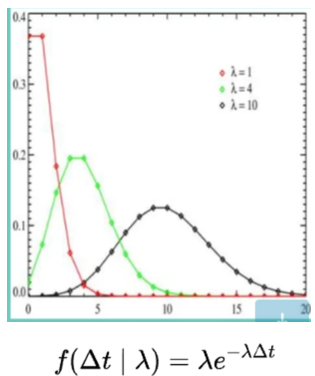


**Second Component is Gamma distribution:** Gamma distribution to describe the variation in buying behavior across population

**Gamma distribution** helps us to predict the "Waiting Time" between two related events.

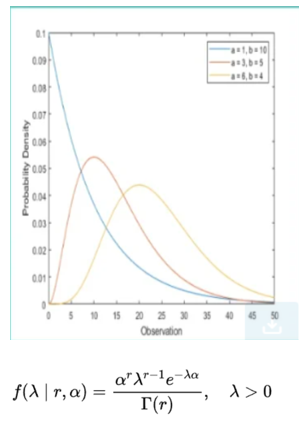

**Third Component is Geometric distribution:** Deactivation of a customer is modeled as a geometric process

**Geometric distribution** helps us to predict the possibility of Dropout (possibility of becoming inactive) for a customer.

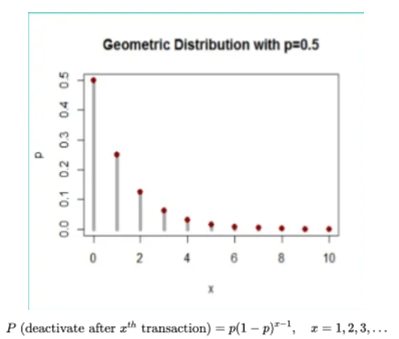

**Fourth Component is Beta distribution:** Beta distribution to describe the variation in deactivation probability

**Beta distirbution** helps us to determine more accurate 'Dropout' possibility for each customer.

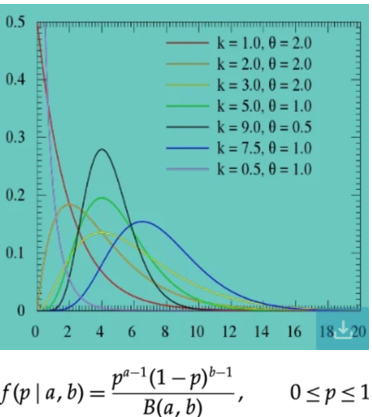

**Tying everything together: a mathematical model of likelihood on an individual level**

**x:** the number of repeat transactions. This is also called the (repeat) frequency.

**tx:** the age of the customer at his last transaction time. This is also called recency.

**T:** the age of the customer at the point of analysis.

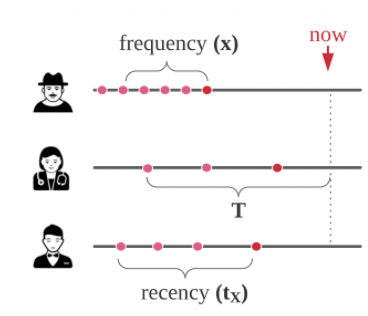 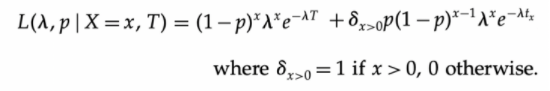

## **Step 3.1. Fitting Model of BG-NBD**

### **Step 3.1.1. Prediction of Number of Orders for next 3 months and adding "exp_sales_3_month" variable to clv dataframe**

In [10]:
bgf = BetaGeoFitter(penalizer_coef=0.001)

bgf.fit(clv_df['frequency'],
        clv_df['recency_clv_weekly'],
        clv_df['T_weekly'])

/opt/conda/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


<lifetimes.BetaGeoFitter: fitted with 19945 subjects, a: 0.00, alpha: 75.71, b: 0.00, r: 3.65>

In [11]:
clv_df["exp_sales_3_month"] = bgf.predict(4 * 3,
                                           clv_df['frequency'],
                                           clv_df['recency_clv_weekly'],
                                           clv_df['T_weekly'])
clv_df.sort_values("exp_sales_3_month", ascending=False).head(10)

,customer_id,recency_clv_weekly,T_weekly,frequency,monetary_clv_avg,exp_sales_3_month
7330,a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,62.000,67.000,52.000,166.225,4.680
15611,4a7e875e-e6ce-11ea-8f44-000d3a38a36f,39.000,40.000,29.000,165.298,3.386
8328,1902bf80-0035-11eb-8341-000d3a38a36f,28.000,33.000,25.000,97.440,3.163
19538,55d54d9e-8ac7-11ea-8ec0-000d3a38a36f,52.000,58.000,31.000,228.530,3.110
14373,f00ad516-c4f4-11ea-98f7-000d3a38a36f,38.000,46.000,27.000,141.355,3.022
10489,7af5cd16-b100-11e9-9757-000d3a38a36f,103.000,112.000,43.000,157.113,2.982
4315,d5ef8058-a5c6-11e9-a2fc-000d3a38a36f,133.000,147.000,49.000,161.847,2.837
6756,27310582-6362-11ea-a6dc-000d3a38a36f,62.000,64.000,29.000,168.881,2.805
6666,53fe00d4-7b7a-11eb-960b-000d3a38a36f,9.000,13.000,17.000,259.865,2.794
10536,e143b6fa-d6f8-11e9-93bc-000d3a38a36f,104.000,113.000,40.000,176.200,2.776


### **Step 3.1.2. Prediction of Number of Orders for next 6 months and adding "exp_sales_6_month" variable to clv dataframe**

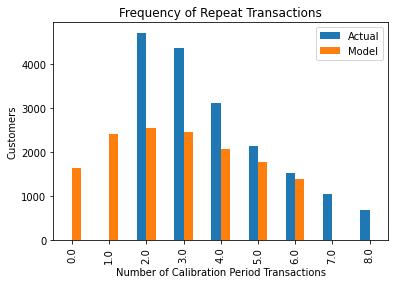

In [12]:
clv_df["exp_sales_6_month"] = bgf.predict(4 * 6,
                                           clv_df['frequency'],
                                           clv_df['recency_clv_weekly'],
                                           clv_df['T_weekly'])
plot_period_transactions(bgf)
plt.show(block=True)

## **Step 3.2. Fitting Model of Gamma-Gamma**

### **Step 3.2.1. Prediction of Average Value of the Purchases and adding "exp_average_value" variable to clv dataframe**

In [13]:
ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(clv_df['frequency'], clv_df['monetary_clv_avg'])
ggf.conditional_expected_average_profit(clv_df['frequency'],
                                        clv_df['monetary_clv_avg']).head(10)

clv_df["exp_average_value"] = ggf.conditional_expected_average_profit(clv_df['frequency'],
                                                                       clv_df['monetary_clv_avg'])



In [14]:
clv = ggf.customer_lifetime_value(bgf,
                                   clv_df['frequency'],
                                   clv_df['recency_clv_weekly'],
                                   clv_df['T_weekly'],
                                   clv_df['monetary_clv_avg'],
                                   time=6,  # 6 months
                                   freq="W",  # Tenure frequency Weekly
                                   discount_rate=0.01)

clv_df["clv"] = clv
clv

0       399.169
1       199.566
2       170.392
3        99.108
4        95.351
          ...  
19940   144.683
19941   213.219
19942   224.249
19943   221.237
19944   121.353
Name: clv, Length: 19945, dtype: float64

## **Step 3.3. Calculating CLV for 6 months and Adding to clv dataframe**

### **Step 3.3.1. Observing Max 20 Value of CLV**

In [15]:
clv_df.sort_values("clv", ascending=False).head(20)

,customer_id,recency_clv_weekly,T_weekly,frequency,monetary_clv_avg,exp_sales_3_month,exp_sales_6_month,exp_average_value,clv
9055,47a642fe-975b-11eb-8c2a-000d3a38a36f,2.000,8.000,4.000,1401.800,1.097,2.194,1449.060,3336.366
13880,7137a5c0-7aad-11ea-8f20-000d3a38a36f,6.000,13.000,11.000,758.085,1.982,3.964,767.361,3191.946
17323,f59053e2-a503-11e9-a2fc-000d3a38a36f,51.000,101.000,7.000,1106.467,0.723,1.447,1127.612,1711.949
12438,625f40a2-5bd2-11ea-98b0-000d3a38a36f,74.000,74.000,16.000,501.874,1.575,3.151,506.167,1673.283
7330,a4d534a2-5b1b-11eb-8dbd-000d3a38a36f,62.000,67.000,52.000,166.225,4.680,9.359,166.712,1637.128
8868,9ce6e520-89b0-11ea-a6e7-000d3a38a36f,3.000,34.000,8.000,601.226,1.275,2.549,611.493,1635.670
6402,851de3b4-8f0c-11eb-8cb8-000d3a38a36f,8.000,9.000,2.000,862.690,0.801,1.602,923.680,1552.466
6666,53fe00d4-7b7a-11eb-960b-000d3a38a36f,9.000,13.000,17.000,259.865,2.794,5.588,262.073,1536.472
19538,55d54d9e-8ac7-11ea-8ec0-000d3a38a36f,52.000,58.000,31.000,228.530,3.110,6.220,229.607,1498.470
14858,031b2954-6d28-11eb-99c4-000d3a38a36f,14.000,15.000,3.000,743.587,0.880,1.761,778.050,1437.188


# **Task 4. Creating Segments According with CLV**

## **Step 4.1 Creating 4 Segments of Customers According to CLV for 6 Months and Adding group Names Into Dataframe**

In [16]:
clv_df["segment"] = pd.qcut(clv_df["clv"], 4, labels=["D", "C", "B", "A"])
clv_df.groupby("segment").agg({"mean", "sum"})

recency_clv_weekly            T_weekly            frequency           monetary_clv_avg             exp_sales_3_month          exp_sales_6_month          exp_average_value                 clv            
                      mean        sum     mean        sum      mean       sum             mean         sum              mean      sum              mean      sum              mean         sum    mean         sum
segment                                                                                                                                                                                                           
D                  138.665 691523.000  161.994 807864.000     3.769 18797.000           93.209  464833.353             0.410 2043.330             0.819 4086.661            98.751  492472.841  80.537  401635.658
C                   92.223 459824.000  112.570 561275.000     4.406 21969.000          125.844  627458.990             0.527 2627.408             1.054 5254.815           132.310  659699.478 138.738  691747.585
B                   81.502 406368.000   99.952 498361.000     5.093 25394.000          160.562  800559.733             0.604 3009.444             1.207 6018.887           167.918  837238.420 200.219  998291.913
A                   66.951 333816.000   82.193 409815.000     6.644 33129.000          228.793 1140762.651             0.776 3871.075             1.553 7742.150           237.987 1186601.676 363.857 1814190.784

## **Step 4.2 Suggesting to Management Brief Action Plan for 6 Months in 2 of 4 Groups**

In [17]:
clv_df.info()
clv_df.describe().T
clv_df.groupby("segment").agg({"clv": ["mean", "sum", "count", "max", "min", "std"]})

clv_df.shape
clv_df.sort_values("clv", ascending=False).head(20)
clv_df.sort_values("clv", ascending=False).tail(20)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19945 entries, 0 to 19944
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   customer_id         19945 non-null  object  
 1   recency_clv_weekly  19945 non-null  float64 
 2   T_weekly            19945 non-null  float64 
 3   frequency           19945 non-null  float64 
 4   monetary_clv_avg    19945 non-null  float64 
 5   exp_sales_3_month   19945 non-null  float64 
 6   exp_sales_6_month   19945 non-null  float64 
 7   exp_average_value   19945 non-null  float64 
 8   clv                 19945 non-null  float64 
 9   segment             19945 non-null  category
dtypes: category(1), float64(8), object(1)
memory usage: 1.5+ MB


,customer_id,recency_clv_weekly,T_weekly,frequency,monetary_clv_avg,exp_sales_3_month,exp_sales_6_month,exp_average_value,clv,segment
951,b5e6f2a2-9f75-11e9-a2fc-000d3a38a36f,356.000,390.000,5.000,46.046,0.223,0.446,48.089,22.503,D
19823,4eb38320-a691-11e9-a2fc-000d3a38a36f,361.000,378.000,2.000,64.985,0.150,0.299,71.593,22.467,D
15765,a15d4e5c-9efe-11e9-9897-000d3a38a36f,396.000,425.000,4.000,54.995,0.183,0.367,57.861,22.273,D
14980,0769f8d0-d627-11e9-93bc-000d3a38a36f,58.000,93.000,2.000,22.490,0.402,0.804,26.201,22.111,D
13151,352b2622-a9fe-11e9-a2fc-000d3a38a36f,207.000,219.000,2.000,40.480,0.230,0.460,45.417,21.942,D
5481,380ddc7c-9d92-11e9-9897-000d3a38a36f,381.000,394.000,5.000,44.990,0.221,0.442,47.005,21.808,D
18859,377f0a54-ab90-11e9-a2fc-000d3a38a36f,157.000,180.000,2.000,33.995,0.265,0.531,38.490,21.431,D
7035,37c86d08-a739-11e9-a2fc-000d3a38a36f,322.000,337.000,2.000,55.435,0.164,0.329,61.392,21.179,D
3096,4bb3a040-acc9-11e9-a2fc-000d3a38a36f,136.000,159.000,3.000,26.823,0.340,0.680,29.435,21.013,D
10978,d2cee8dc-9f09-11e9-9897-000d3a38a36f,372.000,423.000,4.000,47.742,0.184,0.368,50.369,19.467,D


* **Target Group could be B.**

* **First 2 Customers in A group is Most Valuable Customers and They should be use marketing.**

* **B segment have better both of standart deviation and mean. Campaigns should be implemented on B segment.**

# **Resources:**

https://aliz.ai/en/blog/part-1-customer-lifetime-value-estimation-via-probabilistic-modeling/

https://www.slideshare.net/YunusTalipEROL/customer-life-time-value-249754956

https://www.analyticsvidhya.com/blog/2020/10/a-definitive-guide-for-predicting-customer-lifetime-value-clv/